In [1]:
## This notebook contains what you need to assess single new sequence and compare it to existing stats

import os
from esm import pretrained, Alphabet, BatchConverter
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import string
from pathlib import Path
import numpy as np
import torch
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import SeqIO
from tqdm import tqdm
import pandas as pd
import esm
import seaborn as sns


from get_biochemical_benchmarks import (
    get_basic_props,
    query # this gets some sampled stats, but could take a while to run
)

from get_perplexity_benchmarks import (
    compute_masked_perplexity_simplified,
    compute_estimated_masked_perplexity,
    compute_estimated_perplexity_by_cross_entropy
)

In [ ]:
# load previous samples and stats
biochemical_sample = pd.read_csv("biochemical_benchmarks/uniprot50_biochemical_summary.csv")
global_keys = list(biochemical_sample.columns)
biochemical_stats = pd.read_csv("biochemical_benchmarks/uniprot50_biochemical_stats.csv")
print(global_keys)
biochemical_stats

TypeError: 'str' object cannot be interpreted as an integer

In [3]:
query()

running query
Saved CSV to: biochemical_benchmarks/uniprot50_biochemical_summary.csv

Summary Statistics:
              length          gravy  instability_index  isoelectric_point  \
count  490948.000000  490948.000000      490948.000000      490948.000000   
mean     1121.656986      -0.335756          42.694287           6.532418   
std       765.005793       0.330337          12.138966           1.696155   
min        12.000000      -3.862436         -50.492857           4.050028   
25%       773.000000      -0.514808          35.574108           5.239896   
50%       917.000000      -0.318192          42.157023           6.032743   
75%      1197.000000      -0.143469          49.187190           8.074681   
max     49499.000000       4.110610         265.813143          11.999968   

         aromaticity  charge_at_ph7  
count  490948.000000  490948.000000  
mean        0.077376     -18.753563  
std         0.026830      59.908267  
min         0.000000   -3834.386327  
25%       

In [4]:
sns.set(style="whitegrid")
for key in global_keys:
    plt.figure(figsize=(6, 4))
    sns.histplot(biochemical_sample[key], kde=True, bins=50)
    plt.title(f"{key} Distribution")
    plt.xlabel(key)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

NameError: name 'global_keys' is not defined

In [6]:
# load previous samples and stats
biochemical_sample = pd.read_csv("biochemical_benchmarks/uniprot50_biochemical_summary.csv")
global_keys = list(biochemical_sample.columns)
biochemical_stats = pd.read_csv("biochemical_benchmarks/uniprot50_biochemical_stats.csv")
print(global_keys)
biochemical_stats

['length', 'gravy', 'instability_index', 'isoelectric_point', 'aromaticity', 'charge_at_ph7', 'sequence_id']


,Unnamed: 0,length,gravy,instability_index,isoelectric_point,aromaticity,charge_at_ph7
0,count,6.864257e+06,6.864257e+06,6.864257e+06,6.864257e+06,6.864257e+06,6.864257e+06
1,mean,2.848442e+02,-2.265938e-01,4.251655e+01,7.307115e+00,8.211672e-02,-1.851706e+00
2,std,3.387145e+02,4.643056e-01,1.500451e+01,2.154167e+00,3.686661e-02,1.966890e+01
3,min,1.100000e+01,-4.320000e+00,-7.686772e+01,4.050028e+00,0.000000e+00,-3.298783e+03
4,25%,1.080000e+02,-4.845361e-01,3.312532e+01,5.337261e+00,5.714286e-02,-6.097850e+00
5,50%,1.930000e+02,-2.492188e-01,4.118776e+01,6.819394e+00,7.936508e-02,-2.833196e-01
6,75%,3.480000e+02,-9.604520e-03,5.029230e+01,9.262318e+00,1.035197e-01,4.809689e+00
7,max,4.949900e+04,4.371795e+00,5.591109e+02,1.199997e+01,9.767442e-01,2.464782e+03


In [9]:
sample_seq = "MNYRCVKNGRKCEMIESHERKKTMVIVNYYTLQAALHMLIKATHISRVRIDKGGEAMGMQACYPNNTNTQGGPELMLSCKVAFNTAIMPQDKGPRYLLGWWPADKGDTSANRRRWGQDA"
sample_name = "Steered Zinc Finger"
new_sample = get_basic_props(sample_seq)
print(new_sample)

{'length': 119, 'gravy': -0.6252100840336137, 'instability_index': 40.847899159663854, 'isoelectric_point': 9.573248863220215, 'aromaticity': 0.07563025210084034, 'charge_at_ph7': 7.727853393388321}


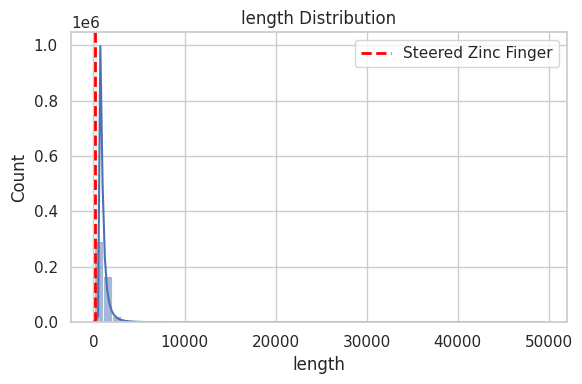

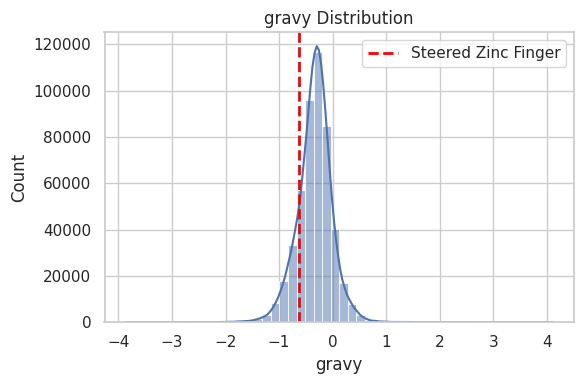

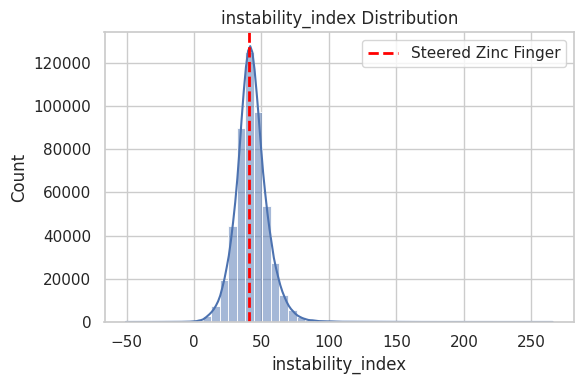

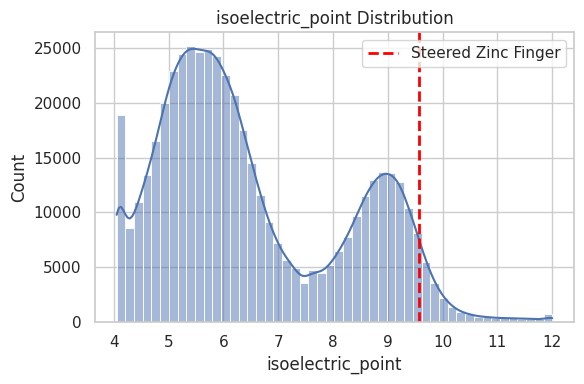

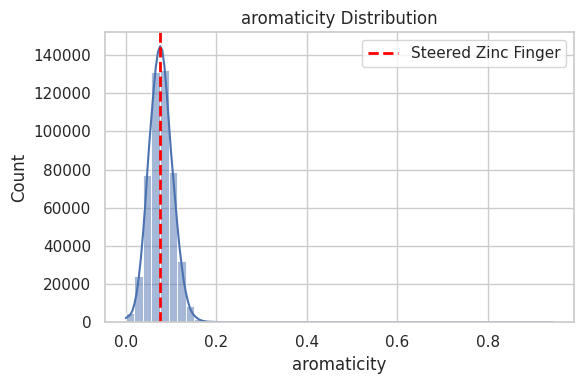

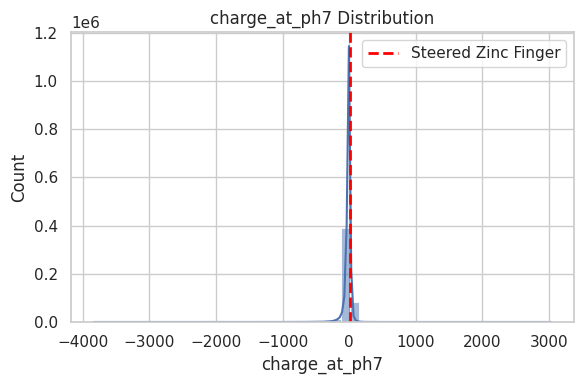

In [10]:
# Original keys and new sample
global_keys = ['length', 'gravy', 'instability_index', 'isoelectric_point', 'aromaticity', 'charge_at_ph7']

sns.set(style="whitegrid")
for key in global_keys:
    plt.figure(figsize=(6, 4))
    sns.histplot(biochemical_sample[key], kde=True, bins=50)
    plt.axvline(new_sample[key], color='red', linestyle='--', linewidth=2, label=sample_name)
    plt.title(f"{key} Distribution")
    plt.xlabel(key)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [11]:
# Perplexity Stats
df = pd.read_csv("biochemical_benchmarks/perplexity_sample_1.csv")
df_stats = pd.read_csv("biochemical_benchmarks/perplexity_sample_1_simple_stats.csv")
df.columns

Index(['Unnamed: 0', 'sequence', 'perplexity', 'unprot_id'], dtype='object')

In [12]:
perplexities = df["perplexity"].to_list()

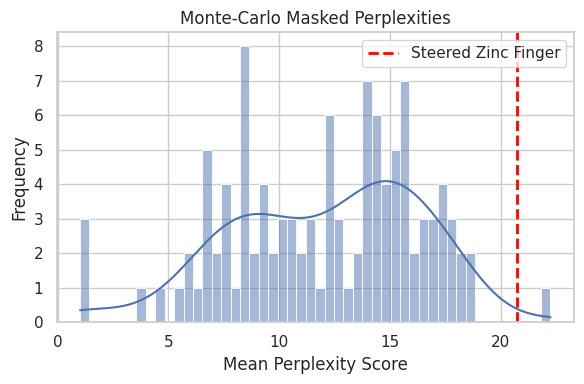

In [14]:
sample_seq = "MNYRCVKNGRKCEMIESHERKKTMVIVNYYTLQAALHMLIKATHISRVRIDKGGEAMGMQACYPNNTNTQGGPELMLSCKVAFNTAIMPQDKGPRYLLGWWPADKGDTSANRRRWGQDA"
new_sample_score = compute_estimated_masked_perplexity(sample_seq, lambda_t=20, num_samples=100)

sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.histplot(perplexities, bins=50, kde=True)
plt.axvline(new_sample_score, color='red', linestyle='--', linewidth=2, label='Steered Zinc Finger')
plt.title("Monte-Carlo Masked Perplexities")
plt.xlabel("Mean Perplexity Score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()
